# SA

1. list-based simulated annealing
    ###### 1. A list-based simulated annealing algorithm with crossover operator for the traveling salesman problem (2021)
    2. List-Based Simulated Annealing Algorithm for Traveling Salesman Problem, Zhan (doi.org/10.1155/2016/1712630) (2015)
    ###### 3. Enhanced List-Based Simulated Annealing Algorithm for Large-Scale Traveling Salesman Problem
    4. A hybrid genetic algorithm, list-based simulated annealing algorithm, and different heuristic algorithms for travelling salesman problem (doi.org/10.1093/jigpal/jzac028)
2. nested simulated annealing
    1. Nested Simulated Annealing Algorithm to Solve Large-Scale TSP Problem
3. tabu search simulated annealing
    ###### 1. Developing a dynamic neighborhood structure for an adaptive hybrid simulated annealing – tabu search algorithm to solve the symmetrical traveling salesman problem
    
###### 6. Solving the traveling salesman problem based on an adaptive simulated annealing algorithm with greedy search

### XGeng, 2011, Adaptive SA with Greedy Search
1. vertex insert (10%), block insert (1%), block reverse (89%)
2. two-stage adaptive local search
3. greedy search?

### YLin, 2016, Dynamic Neighborhood Structure, Adaptive Hybrid SA - Tabu Search
1. (n-opt randomness) -> circle-directed mutation -> dynamic neighborhood structure -> adaptive + eliminate randomness
2. adaptive parameters
3. sa + tabu search

## nested simulated annealing ##
k-means clustering

In [161]:
# package list
import numpy as np
import sys
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import time

In [2]:
# Plot Settings
PLOT_MODE = True # Draw Route
PLT_INTERVAL = 100 # Draw Route every 100 iterations
plt.ion()

In [3]:
def fileloader():
    with open(file_path, "r") as file:
        file_str = file.readlines()

    # Get the coordinates of cities
    coord_str = file_str[8:-1]  # first city string to last city string (EOF 전까지)
    coord_list = np.zeros((len(coord_str), 2))
    for idx, item in enumerate(coord_str):
        items = item.split()
        coord_list[idx, 0], coord_list[idx, 1] = float(items[1]), float(items[2])

    return coord_list

In [213]:
def path_cost(path, path_map):
    # The array of cost between cities in the path
    cnt_cities = path_map.shape[0]
    cost_arr = np.zeros(cnt_cities)
    for i in range(cnt_cities):
        cost_arr[i] = path_map[path[i], path[i+1]]

    return cost_arr

In [214]:
def cluster(coord_list, n_cluster):
    KMean = KMeans(init='k-means++', n_clusters=n_cluster, max_iter=100)
    KMean.fit(coord_list)

#     for l in range(np.min(KMean.labels_), np.max(KMean.labels_)+1):
#         plt.scatter(coord_list[KMean.labels_ == l, 0], coord_list[KMean.labels_ == l,1], label=l, s=2)
#     plt.show()
    
    cluster_path_map = np.zeros((n_cluster, n_cluster))
    
    for l1 in range(0, n_cluster-1):
        for l2 in range(l1+1, n_cluster):
            path_map_slice = path_map[np.where(KMean.labels_ == l1)[0], :][:, np.where(KMean.labels_ == l2)[0]]
            min_dist = np.min(path_map_slice)
            cluster_path_map[l1,l2], cluster_path_map[l2,l1] = min_dist, min_dist

    return cluster_path_map, KMean.labels_

In [215]:
def greedy_cluster(n_cluster, cluster_path_map):
    cluster_path = np.zeros(n_cluster+1, dtype=np.int32)
    clusters_tovisit = np.ones((n_cluster), dtype=np.bool_)
    clusters_tovisit[0] = False
    for i in range(1, n_cluster):
        start_idx = cluster_path[i - 1]
        distance_from_start = cluster_path_map[start_idx, :]
        nearest_list = np.argsort(distance_from_start)
        for idx in range(len(nearest_list)):
            if clusters_tovisit[nearest_list[idx]]:
                nearest_cluster = nearest_list[idx]
                break
        clusters_tovisit[nearest_cluster] = False
        cluster_path[i] = nearest_cluster
    return cluster_path

In [393]:
def greedy_cities(city_idx, path_map, start_idx, end_idx):
#     print(city_idx.shape[0])
    cities_path = np.zeros(city_idx.shape[0], dtype=np.int32)
    cities_path[0], cities_path[-1] = start_idx, end_idx
    cities_path_map = np.full(path_map.shape, fill_value=np.inf)
    cities_path_map[np.ix_(city_idx, city_idx)] = path_map[city_idx, :][:, city_idx]
    cities_tovisit = np.ones((path_map.shape[0]), dtype=np.bool_)
    cities_tovisit[start_idx] = False
    cities_tovisit[end_idx] = False
    for i in range(1, city_idx.shape[0] - 1):
        start_idx = cities_path[i - 1]
        distance_from_start = cities_path_map[start_idx, :]
        nearest_list = np.argsort(distance_from_start)
        for idx in range(len(nearest_list)):
            if cities_tovisit[nearest_list[idx]]:
                nearest_city = nearest_list[idx]
                break
        cities_tovisit[nearest_city] = False
        cities_path[i] = nearest_city
    return cities_path

In [218]:
def block_reverse(path):
    path_len = path.shape[0]
    sel_idx = np.sort(np.random.choice(np.arange(1, path_len), 2))
    new_path = path.copy()
    new_path[sel_idx[0]:sel_idx[1]] = np.flip(path[sel_idx[0]:sel_idx[1]])
    return new_path

In [219]:
def block_insert(path):
    path_len = path.shape[0]
    sel_idx = np.sort(np.random.choice(np.arange(1, path_len), 3))
    new_path = path.copy()
    new_path[sel_idx[0]:sel_idx[0]+sel_idx[2]-sel_idx[1]] = path[sel_idx[1]:sel_idx[2]]
    new_path[sel_idx[0]+sel_idx[2]-sel_idx[1]:sel_idx[2]] = path[sel_idx[0]:sel_idx[1]]
    return new_path

In [220]:
def vertex_insert(path):
    path_len = path.shape[0]
    sel_idx = np.sort(np.random.choice(np.arange(1, path_len-1), 2))
    new_path = path.copy()
    new_path[sel_idx[0]+1:sel_idx[1]+1] = path[sel_idx[0]:sel_idx[1]]
    new_path[sel_idx[0]] = path[sel_idx[1]]
    return new_path

In [301]:
def sa(path, path_map):
    
#     sa_start_time = time.time()
    
    path_len = path.shape[0]
    path_current = path.copy()
    cost_current = np.sum(path_cost(path, path_map))
    
#     print(cost_current)
    
    t_initial = 1000.
    OPT_pseudo = cost_current / 3.
    
    
    # stage 1
    
    t_end = 0.005
    t_greedy = path_len // 3
    t_cool = (16. * np.sqrt(path_len) - 1.) / (16. * np.sqrt(path_len))
    
    G = 0
    t_current = t_initial
    
    while t_current >= t_end:
        
        new_path_list = []
        new_cost_list = []
        
        while G < t_greedy:
            
            path_new = None
            
            random_mutation_selection = np.random.randint(100)
            if random_mutation_selection < 89:
                path_new = block_reverse(path_current)
            elif random_mutation_selection > 89:
                path_new = vertex_insert(path_current)
            else:
                path_new = block_insert(path_current)

            cost_new = np.sum(path_cost(path_new, path_map))

            if cost_new <= cost_current:
                path_current = path_new
                cost_current = cost_new
                break
            else:
                new_path_list.append(path_new)
                new_cost_list.append(cost_new)
                G += 1
                
        if G == t_greedy:
            p = np.exp(-((np.min(np.array(new_cost_list)) - cost_current) / t_current) * (10. * path_len / OPT_pseudo))
            if np.random.rand(1) < p:
#                 new_path_list = np.array(new_path_list)
                new_cost_list = np.array(new_cost_list)
                path_current = new_path_list[np.argmin(new_cost_list)]
                cost_current = np.min(new_cost_list)
        
        G=0
        t_current *= t_cool
    
    
    # stage 2
    
    t_end = 0.0025
    t_greedy = 3 * path_len // 2
    t_cool = (12. * np.sqrt(path_len) - 1.) / (12. * np.sqrt(path_len))
    
    G = 0
    t_current = t_initial
    
    # stage 2
    while t_current >= t_end:
        
        new_path_list = []
        new_cost_list = []
        
        while G < t_greedy:
            
            path_new = None
            
            random_mutation_selection = np.random.randint(100)
            if random_mutation_selection < 89:
                path_new = block_reverse(path_current)
            elif random_mutation_selection > 89:
                path_new = vertex_insert(path_current)
            else:
                path_new = block_insert(path_current)

            cost_new = np.sum(path_cost(path_new, path_map))

            if cost_new <= cost_current:
                path_current = path_new
                cost_current = cost_new
                break
            else:
                new_path_list.append(path_new)
                new_cost_list.append(cost_new)
                G += 1
                
        if G == t_greedy:
            p = np.exp(-((np.min(np.array(new_cost_list)) - cost_current) / t_current) * (10. * path_len / OPT_pseudo))
            if np.random.rand(1) < p:
#                 new_path_list = np.array(new_path_list)
                new_cost_list = np.array(new_cost_list)
                path_current = new_path_list[np.argmin(new_cost_list)]
                cost_current = np.min(new_cost_list)
        
        G=0
        t_current *= t_cool
        
#     print(cost_current)
#     print(time.time()-sa_start_time)
    return path_current, cost_current

In [239]:
def sa_large(coord_list):
    n_cluster = int(np.floor(np.sqrt(coord_list.shape[0])))
    
    sa_large_start = time.time()
    
    cluster_path_map, cluster_labels = cluster(coord_list, n_cluster)
    print('clusterized', time.time()-sa_large_start)
    
    cluster_path = greedy_cluster(n_cluster, cluster_path_map)
    print('intercluster greedy', time.time()-sa_large_start)
    
    cluster_path, cluster_cost = sa(cluster_path, cluster_path_map)
    print('intercluster sa', time.time()-sa_large_start)
    
#     cluster_edge_idx = []
    
#     curr_cluster_idx = np.where(KMean.labels_ == cluster_path[-1])[0]
#     path_map_slice = path_map[np.where(KMean.labels_ == cluster_path[-2])[0], :][:, curr_cluster_idx]
#     slice_idx = np.unravel_index(np.argmin(path_map_slice, axis=None), path_map_slice.shape)
#     start_idx = curr_cluster_idx[slice_idx[0]]
#     for c in range(n_cluster):
#         curr_cluster_idx = np.where(KMean.labels_ == cluster_path[c])[0]
#         next_cluster_idx = np.where(KMean.labels_ == cluster_path[c+1])[0]
#         path_map_slice = path_map[curr_cluster_idx, :][:, next_cluster_idx]
#         slice_idx = np.unravel_index(np.argmin(path_map_slice, axis=None), path_map_slice.shape)
#         end_idx = curr_cluster_idx[slice_idx[0]]
#         next_start_idx = next_cluster_idx[slice_idx[1]]
#         cluster_edge_idx.append((start_idx, end_idx))
# #         print(start_idx, end_idx)
#         start_idx = next_start_idx
    
    cluster_edge_idx = []
    
    curr_cluster_idx = np.where(KMean.labels_ == cluster_path[-1])[0]
    path_map_slice = path_map[np.where(KMean.labels_ == cluster_path[-2])[0], :][:, curr_cluster_idx]
    slice_idx = np.unravel_index(np.argmin(path_map_slice, axis=None), path_map_slice.shape)
    start_idx = curr_cluster_idx[slice_idx[1]]
    for c in range(n_cluster):
        next_cluster_idx = np.where(KMean.labels_ == cluster_path[c+1])[0]
        path_map_slice = path_map[curr_cluster_idx, :][:, next_cluster_idx]
        slice_idx = np.unravel_index(np.argmin(path_map_slice, axis=None), path_map_slice.shape)
        end_idx = curr_cluster_idx[slice_idx[0]]
        next_start_idx = next_cluster_idx[slice_idx[1]]
        while start_idx == end_idx:
            path_map_slice[slice_idx] = np.inf
            slice_idx = np.unravel_index(np.argmin(path_map_slice, axis=None), path_map_slice.shape)
            end_idx = np.where(KMean.labels_ == cluster_path[c])[0][slice_idx[0]]
        cluster_edge_idx.append((start_idx, end_idx))
        start_idx = next_start_idx
        curr_cluster_idx = next_cluster_idx
        
        greedy_cities()
        
        
        
    cluster_edge_idx
        
    
#         sa()
    
#     conquer
    return cluster_path, cluster_cost

In [240]:
sa_large(coord_list)

clusterized 3.3410391807556152
intercluster greedy 3.3417201042175293
29492.017429774125
intercluster sa 6.197703123092651


(array([  0,  91,  82,  26,  75,  68,  38,  10,  45,  57,  30,  11,  29,
         92,  67,  17, 101,  79,  36,  70,  34,  58,  41,  14,  71,  97,
         86,  37,  99,  43,  20,  81,  90,   7,  28,   3,  46,  69,  18,
        100,  32,  56,   4,  49,  77,  53,  12,  83,  35,  62,  22,  98,
         15,  27,  50,  73,   1,  63,  33,  47,  84,  40,   6,  94,  19,
         42,  93,  54,  16,  85,  72,   9,  60, 102,  23,  51,   2,  65,
         13,  44,  59,  95,  61,  25,  89,  39,  66,  78,  74,  96,  24,
         52,  55,   8,  87,  88,  31,  21,  48,  80,   5,  76,  64,   0],
       dtype=int32),
 10347.889084671837)

In [306]:
# test

In [169]:
cstart = time.time()
n_cluster = int(np.floor(np.sqrt(coord_list.shape[0])))
KMean = KMeans(init='k-means++', n_clusters=n_cluster, max_iter=300)
KMean.fit(coord_list)
cend = time.time()
print('kmeans time:', cend-cstart)

kmeans time: 1.3310458660125732


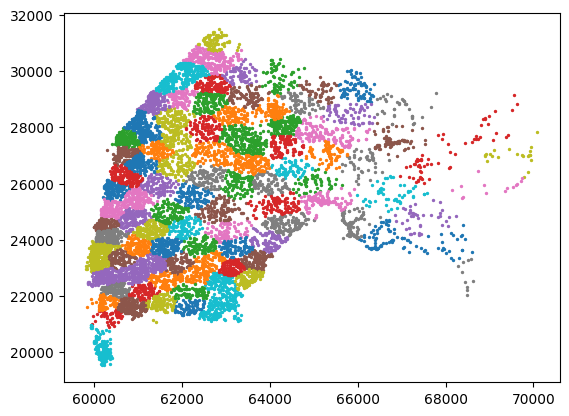

In [170]:
for l in range(np.min(KMean.labels_), np.max(KMean.labels_)+1):
    plt.scatter(coord_list[KMean.labels_ == l, 0], coord_list[KMean.labels_ == l,1], label=l, s=2)
#     print(coord_list[KMean.labels_ == l, :].shape)
plt.show()

In [253]:
path_map = euclidean_distances(coord_list, coord_list)

In [302]:
cluster_path_map = np.zeros((np.max(KMean.labels_)+1, np.max(KMean.labels_)+1))
cluster_min_idx = np.zeros((np.max(KMean.labels_)+1, np.max(KMean.labels_)+1, 2))
cluster_path_map.shape, cluster_min_idx.shape, cluster_path_map

((103, 103),
 (103, 103, 2),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]))

In [303]:
cpstart = time.time()
for l1 in range(0, np.max(KMean.labels_)):
    for l2 in range(l1+1, np.max(KMean.labels_)+1):
        path_map_slice = path_map[np.where(KMean.labels_ == l1)[0], :][:, np.where(KMean.labels_ == l2)[0]]
        min_dist = np.min(path_map_slice)
        cluster_path_map[l1,l2], cluster_path_map[l2,l1] = min_dist, min_dist
        
#         # finding min distance city between clusters
#         x, y = np.where(path_map == min_dist)
#         xi = np.intersect1d(np.where(KMean.labels_ == l1)[0], x)
#         yi = np.intersect1d(np.where(KMean.labels_ == l2)[0], y)
#         xx, yy = np.where(path_map[xi, :][:, yi] == min_dist)
#         cluster_min_idx[l1, l2, 0] = xi[xx]
#         cluster_min_idx[l1, l2, 1] = yi[yy]


cpend = time.time()
print('cluster pathmap time', cpend-cpstart)
print(cluster_path_map)

cluster pathmap time 1.9128398895263672
[[   0.         4539.82378513 3455.63140026 ... 3368.19268567
  3366.66667327 5043.50518081]
 [4539.82378513    0.         3995.30975019 ...  534.37404919
  5083.33330885   23.57027319]
 [3455.63140026 3995.30975019    0.         ... 3150.04414819
   117.85106891 3947.74905329]
 ...
 [3368.19268567  534.37404919 3150.04414819 ...    0.
  4113.83170644 1055.40939661]
 [3366.66667327 5083.33330885  117.85106891 ... 4113.83170644
     0.         5057.0358214 ]
 [5043.50518081   23.57027319 3947.74905329 ... 1055.40939661
  5057.0358214     0.        ]]


In [304]:
cluster_path = np.zeros(n_cluster+1, dtype=np.int32)
clusters_tovisit = np.ones((n_cluster), dtype=np.bool_)
clusters_tovisit[0] = False
for i in range(1, n_cluster):
    start_idx = cluster_path[i - 1]
    distance_from_start = cluster_path_map[start_idx, :]
    nearest_list = np.argsort(distance_from_start)
    for idx in range(len(nearest_list)):
        if clusters_tovisit[nearest_list[idx]]:
            nearest_cluster = nearest_list[idx]
            break
    clusters_tovisit[nearest_cluster] = False
    cluster_path[i] = nearest_cluster
print(cluster_path, cluster_path.dtype, cluster_path.shape)

[  0  22  80  34  18  26  69  79   3  62  75  54  96  58  16  42  65   7
  61  52  93  49  67  32  71  12  72  73  78  51  55  63   4  36  30  56
  45  97   8  35  48  64  94  43  88  95  81  13  99   9  17   1 102  50
  29  89  19  33  85  98  90  11  82   6  15  83  47  66  37  10  84  59
  23  53  28  76  40  87  27 101  86  46  44  20  57   5   2  24  39  68
  14  92  60  77  38  21  31  70  41  74  25 100  91   0] int32 (104,)


In [305]:
cluster_path, cluster_cost = sa(cluster_path, cluster_path_map)

26859.377949074908
8764.652944566835
29.38175106048584


In [311]:
cluster_path

array([  0,  22,  80,  34,  69,  79,  16,  58,  96,  54,  75,  31,  62,
         3,  26,  18,  78,  73,  72,  21,  77,  38,   4,  36,  14,  68,
        92,  60,  15,  32,  67,  49,  71,  12,  93,  52,  61,   7,  42,
        65,  20,  57,  44,  46,  86,   5,  23,  53,  28,  76,  84,  40,
        87,  10,  37,  59,  27, 101,   2,  66,  83,  47,  24,  90,  85,
        98,  33,  19,  89,  29,  50,  88, 102,   1,  91,  11,  82,   6,
        39, 100,  25,  74,  94,  43,  95,   9,  99,  13,  81,  17,  64,
        48,   8,  35,  41,  97,  45,  56,  30,  63,  55,  70,  51,   0],
      dtype=int32)

In [366]:
cluster_edge_idx = []
    
curr_cluster_idx = np.where(KMean.labels_ == cluster_path[-1])[0]
path_map_slice = path_map[np.where(KMean.labels_ == cluster_path[-2])[0], :][:, curr_cluster_idx]
slice_idx = np.unravel_index(np.argmin(path_map_slice, axis=None), path_map_slice.shape)
start_idx = curr_cluster_idx[slice_idx[1]]
for c in range(n_cluster):
#     curr_cluster_idx = np.where(KMean.labels_ == cluster_path[c])[0]
    next_cluster_idx = np.where(KMean.labels_ == cluster_path[c+1])[0]
    path_map_slice = path_map[curr_cluster_idx, :][:, next_cluster_idx]
    slice_idx = np.unravel_index(np.argmin(path_map_slice, axis=None), path_map_slice.shape)
    end_idx = curr_cluster_idx[slice_idx[0]]
    next_start_idx = next_cluster_idx[slice_idx[1]]
    
    while start_idx == end_idx:
#         print('duplicate', c)
        path_map_slice[slice_idx] = np.inf
        slice_idx = np.unravel_index(np.argmin(path_map_slice, axis=None), path_map_slice.shape)
        end_idx = np.where(KMean.labels_ == cluster_path[c])[0][slice_idx[0]]
        
    cluster_edge_idx.append((start_idx, end_idx))
    
    print(start_idx, end_idx)
    
#     print(greedy_cities(curr_cluster_idx, path_map, start_idx, end_idx))
#     a = np.full(path_map.shape, fill_value=np.inf)
#     a[np.ix_(curr_cluster_idx, curr_cluster_idx)] = path_map[curr_cluster_idx, :][:, curr_cluster_idx]
#     print(a)
#     print(a[curr_cluster_idx,:][:,curr_cluster_idx])
    
    
    
    start_idx = next_start_idx
    curr_cluster_idx = next_cluster_idx
# cluster_edge_idx

2972 2907
2906 1934
1972 3032
3033 4064
4226 5146
5212 5365
5366 6060
6132 6532
6494 6972
7048 7998
8047 7848
7770 6920
6796 6051
6052 5551
5516 5207
5238 4834
4777 5356
5390 6590
6650 7166
7080 6361
6296 5272
5174 3876
3839 2959
2848 3056
3163 2791
2790 3996
3997 5172
5135 5663
5740 7201
7161 8090
8121 8990
9027 8570
8543 7943
7914 8484
8572 8907
8879 8763
8740 9134
9182 9115
9116 9303
9346 9844
9857 10215
10245 10244
10218 9677
9639 9738
9784 10173
10217 10461
10507 10555
10549 10607
10608 10628
10625 10568
10537 10499
10523 10565
10573 10564
10438 10140
10119 10127
10154 10241
10186 9958
9949 9698
9689 9606
9612 9361
9307 8971
8951 8793
8830 8116
8060 8086
8145 7956
7955 7562
7563 6896
6848 7348
7410 6607
6576 5854
5786 4660
4589 4630
4719 4662
4631 4846
4910 6181
6284 5473
5474 6547
6616 6071
5820 4851
4824 4415
4414 4346
4309 3233
3232 2403
2458 3089
3140 2394
772 166
773 32
47 325
326 1113
1069 1076
1029 793
748 699
700 1304
1303 2310
2412 2158
2061 960
911 656
720 1220
1221 1616

In [394]:
cluster_edge_idx = []

path_list = []
    
curr_cluster_idx = np.where(KMean.labels_ == cluster_path[-1])[0]
path_map_slice = path_map[np.where(KMean.labels_ == cluster_path[-2])[0], :][:, curr_cluster_idx]
slice_idx = np.unravel_index(np.argmin(path_map_slice, axis=None), path_map_slice.shape)
start_idx = curr_cluster_idx[slice_idx[1]]
for c in range(n_cluster):
#     curr_cluster_idx = np.where(KMean.labels_ == cluster_path[c])[0]
    next_cluster_idx = np.where(KMean.labels_ == cluster_path[c+1])[0]
    path_map_slice = path_map[curr_cluster_idx, :][:, next_cluster_idx]
    slice_idx = np.unravel_index(np.argmin(path_map_slice, axis=None), path_map_slice.shape)
    end_idx = curr_cluster_idx[slice_idx[0]]
    next_start_idx = next_cluster_idx[slice_idx[1]]
    
    while start_idx == end_idx:
#         print('duplicate', c)
        path_map_slice[slice_idx] = np.inf
        slice_idx = np.unravel_index(np.argmin(path_map_slice, axis=None), path_map_slice.shape)
        end_idx = np.where(KMean.labels_ == cluster_path[c])[0][slice_idx[0]]
        
    cluster_edge_idx.append((start_idx, end_idx))
#         print(start_idx, end_idx)
    
    path_list.append(greedy_cities(curr_cluster_idx, path_map, start_idx, end_idx))
#     a = np.full(path_map.shape, fill_value=np.inf)
#     a[np.ix_(curr_cluster_idx, curr_cluster_idx)] = path_map[curr_cluster_idx, :][:, curr_cluster_idx]
#     print(a)
#     print(a[curr_cluster_idx,:][:,curr_cluster_idx])
    
    
    
    start_idx = next_start_idx
    curr_cluster_idx = next_cluster_idx
    
    
print(np.concatenate(path_list))
print(np.concatenate([np.concatenate(path_list), np.array(path_list[0][:1])]))
print(np.concatenate([np.concatenate(path_list), np.array(path_list[0][:1])]).shape)
# cluster_edge_idx

[2972 3020 2973 ... 4000 4128 3072]
[2972 3020 2973 ... 4128 3072 2972]
(10639,)


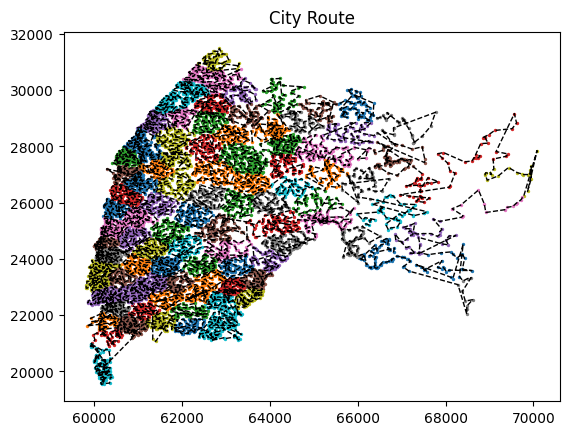

In [396]:
best_path = np.concatenate([np.concatenate(path_list), np.array(path_list[0][:1])])
if PLOT_MODE:
    plt.close()
    figure, ax = plt.subplots()
#     plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
    for l in range(np.min(KMean.labels_), np.max(KMean.labels_)+1):
        plt.scatter(coord_list[KMean.labels_ == l, 0], coord_list[KMean.labels_ == l,1], label=l, s=2)
    plt.title('City Route')
    coord_path = coord_list
    coord_path = np.append(coord_path, coord_path[best_path[0], :].reshape(1, 2), axis=0)
    coord_path[:, :] = coord_path[best_path, :]
    lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--', linewidth=1)
    figure.canvas.draw()
    figure.canvas.flush_events()
    plt.show()

In [398]:
best_path.sum()-best_path[0], np.arange(path_map.shape[0]).sum()

(56578203, 56578203)

In [375]:
path_map.shape

(10638, 10638)

In [337]:
KMean.labels_[2972], KMean.labels_[2907], KMean.labels_[2906], KMean.labels_[1934], KMean.labels_[3069], KMean.labels_[3072]

(0, 0, 22, 22, 51, 51)

In [338]:
path_map[3069, 2972], path_map[3069, 2907], path_map[3072, 2972], path_map[3072, 2907]

(318.41614978708066, 386.5804171049611, 33.333300024651734, 83.3333600107786)

In [339]:
path_map[2972, 2906], path_map[2972, 1934], path_map[2907, 2906], path_map[2907, 1934]

(16.666700051592134, 712.0002941629252, 66.66670001347026, 647.2161960622329)

In [ ]:
for c in range(n_cluster):
    greedy_cities()

## Data Loading

In [4]:
file_path = 'fi10639.tsp'

# 

In [5]:
# First City Index
FIRST_IDX = 0

## SA

In [73]:
# Global Variables
# SA
MAX_EVALUATION = 1000
SUB_ITERATIONS = 100
TEMPERATURE = 100
COOLING_RATIO = 0.5
TEMP_LIMIT = 1

In [74]:
def initialize_greedy(coord_list, first_idx):
    cnt_cities = len(coord_list)
    # Initialize path and insert first city index to the first and last elements
    path = np.zeros(cnt_cities + 1, dtype=np.int32)
    path[0], path[-1] = first_idx, first_idx

    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)

    cities_tovisit = np.ones((cnt_cities), dtype=np.bool_)
    cities_tovisit[first_idx] = False

    # Iteratively Connect nearest cities
    for i in range(1, cnt_cities):
        start_idx = path[i - 1]
        distance_from_start = path_map[start_idx, :]
        nearest_list = np.argsort(distance_from_start)
        for idx in range(len(nearest_list)):
            # check the nearest city is visited
            if cities_tovisit[nearest_list[idx]]:
                nearest_city = nearest_list[idx]
                break
        cities_tovisit[nearest_city] = False
        path[i] = nearest_city

    return path_map, path

def path_cost(path_map, path):
    # The array of cost between cities in the path
    cnt_cities = path_map.shape[0]
    cost_arr = np.zeros(cnt_cities)
    for i in range(cnt_cities):
        cost_arr[i] = path_map[path[i], path[i+1]]

    return cost_arr

In [75]:
def two_opt_swap(path_map, path, iterations, coord_list, sa_start_time):
    cnt_cities = path_map.shape[0]
    # Save the best path

    cost_arr = path_cost(path_map, path)
    best_path = path.copy()
    best_cost = cost_arr.sum()
    
    for i in range(iterations):
        
        ### add time limit ###
        if time.time() - sa_start_time > 53:
            break
        
        curr_path = best_path.copy()
        # Select two indices of flip points
        sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities + 1), 2))

        # Path Flip and update cost array
        curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
        cost_arr = path_cost(path_map, curr_path)

        # Compare to the best path
        curr_cost = cost_arr.sum()
        if curr_cost < best_cost:
            best_path = curr_path
            best_cost = curr_cost
    
    temperature = TEMPERATURE
    while temperature > TEMP_LIMIT:
        
        ### add time limit ###
        if time.time() - sa_start_time > 53:
            break
        
        curr_path = best_path.copy()
        # Select two indices of flip points
        sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities + 1), 2))

        # Path Flip and update cost array
        curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
        cost_arr = path_cost(path_map, curr_path)
        curr_cost = cost_arr.sum()

        if curr_cost <= best_cost:
            best_path, best_cost = curr_path, curr_cost
        else:
            prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))
            if prob > np.random.rand(1):
                best_path, best_cost = curr_path, curr_cost
        temperature = temperature * COOLING_RATIO 
    return best_path, best_cost

In [ ]:
def sa(path_map, path, coord_list):
    best_path, best_cost = path.copy() , path_cost(path_map, path).sum()
    global TEMPERATURE
    
    sa_start_time = time.time()

    for i in range(MAX_EVALUATION):
        
        ### add time limit ###
        if time.time() - sa_start_time > 53:
            break
        
        curr_path = best_path.copy()
        new_path, new_cost = two_opt_swap(path_map, curr_path, SUB_ITERATIONS, coord_list, sa_start_time)

        if new_cost < best_cost:
            best_path, best_cost = new_path, new_cost
            

    if PLOT_MODE:
        plt.close()
        figure, ax = plt.subplots()
        plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
        plt.title('City Route')
        coord_path = coord_list
        coord_path = np.append(coord_path, coord_path[best_path[0], :].reshape(1, 2), axis=0)
        coord_path[:, :] = coord_path[best_path, :]
        lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
        figure.canvas.draw()
        figure.canvas.flush_events()
        plt.show()

    return best_path, best_cost

In [ ]:
# Initialization ###############
initialize = initialize_greedy
################################

# Step 1
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()
# Step 2
path_map, path = initialize(coord_list, FIRST_IDX)

# Step 3
best_path, best_cost = sa(path_map, path, coord_list)

print('Execution Time: ' + str(time.time() - start_time))
print('Path: ' + str(best_path.tolist()))
print('Cost: ' + str(best_cost))